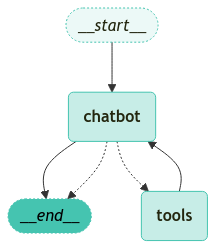

In [1]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()

@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

tools = [search_keyword]
# LLM 초기화
llm = ChatOllama(model="llama3.1:8b")
# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 상태 그래프 생성
graph_builder = StateGraph(State)
# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
# 도구 노드 추가
graph_builder.add_node("tools", tool_node)
# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########
# tools > chatbot
graph_builder.add_edge("tools", "chatbot")
# START > chatbot
graph_builder.add_edge(START, "chatbot")
# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. MemorySaver 추가 ##########
# 메모리 저장소 초기화
memory = MemorySaver()

########## 6. interrupt_before 추가 ##########
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

########## 7. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)

### Graph 멈추기

In [2]:
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

# 질문
question = "AI 관련 최신 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        # print(value)
        pretty_print_messages(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.

[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (76601b45-aee7-4f41-bb1f-9ae033ffa98d)
 Call ID: 76601b45-aee7-4f41-bb1f-9ae033ffa98d
  Args:
    query: AI


In [3]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next

('tools',)

In [6]:
from langchain_teddynote.messages import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
existing_message = snapshot.values["messages"][-1]

# 메시지 트리 표시
display_message_tree(existing_message.tool_calls)

    index [0]
        name: "search_keyword"
        args: {"query": "AI"}
        id: "76601b45-aee7-4f41-bb1f-9ae033ffa98d"
        type: "tool_call"


### Graph 재시작하기

In [7]:
events = graph.stream(None, config)
# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    print(event)
    print("\n")
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

<generator object Pregel.stream at 0x1154f70b0>

In [5]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (76601b45-aee7-4f41-bb1f-9ae033ffa98d)
 Call ID: 76601b45-aee7-4f41-bb1f-9ae033ffa98d
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMidkFVX3lxTE9CTVRYbTdXVjhRVDZPTWJnTk1ReG9IcUE1Z0ltNGNiN2hEQkNLeTRRb2ZYalZvVFpIX1JrVnRQOHJqZ0U0TTZaQ2VETk9VSTA5U0xMczdDX2lUS2RpanBodU1kdXBOa1cwVS13M2tKcjN6dEg2TFHSAWZBVV95cUxOUE15TjlBemFhQUM2NzlEZ244aklLam1GQlBQRVFxSW5ZUmdMVnpxS2FzdE1qOVozRGhpQm40MVFER2RNOWNGc1NHenhrREEzNFEzNEZ2N2xfVk5LekhCOURaNG5IaXc?oc=5", "content": "‘딥시크 쇼크’에 韓 AI 주역 한목소리…“잠재력 이미 충분, 정부 적극 투자해야” - 동아일보"}, {"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE1EUzhSTUJzNTJINVNrMUFwTDlzaloxbElJendybEZpN3hJMkFhOXlOdGJ5akRaUGdNWktUWnpFOVpzS0FoaHU4TllmRGczU2QtSnpyRTd3?oc=5", "content": "카카오, 국내 최초로 오픈AI와 전략적 제휴 체결 - 카카오"}, {"url": "https://news.google.

KeyboardInterrupt: 

In [14]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (e7461367-31de-4c10-80c4-3a48e50ae4a8)
 Call ID: e7461367-31de-4c10-80c4-3a48e50ae4a8
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE9PTTNKM2pLRXlvN3dzckxpeFJ3NFpRZU1mTTFxLVBXeGFpX0lISWY2MjNYV2E2cXdlZkFlRUw5S25SRldtN2dzUnczcElRZ2xIa3BEbDQ4dGc2Q182OW5wTU9nOTVhSld2eHc?oc=5", "content": "오픈AI, 미국서 AI 에이전트 '오퍼레이터' 출시...\"곧 다른 국가에서도 공개\" - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMiXkFVX3lxTE5HaUJoVTJ0Q0JHSDhkQ0Z4VEJjdHhoWVZaRjdYTkVQMk8tblVlcTFOUFNNU19JX2xfbVA5TnYxeXZYRUlIWGVwZ1JpM202WlNSVk9vRE14eEJwYTZjd2fSAXZBVV95cUxNSzVORkZVY3E2Z1FQSkxNRW1tWVNydzZqa2o4NFJUWmxnV01aQ3ZQUGt3NzczeTZmOEtZMmhTaWV2VmExMGJ4Rm9HVlBSU1ZQN2xvc2NoVGQtVmFYNU92VS1BazRoNVpiTmpFd0ZfdXZBcmc4TUpB?oc=5", "content": "오픈AI, AI 에이전트 '오퍼레이터' 공개...예약·쇼핑 척척 - YTN"}, {"

In [49]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    # 메시지 수 및 다음 상태 출력
    print("메시지 수: ", len(state.values["messages"]), 
          "\n다음 노드: ", state.next)
    print("-" * 80)
    # 특정 상태 선택 기준: 채팅 메시지 수
    if len(state.values["messages"]) == 3:
        to_replay = state


메시지 수:  4 
다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  3 
다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 
다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  1 
다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  0 
다음 노드:  ('__start__',)
--------------------------------------------------------------------------------


### checkpoint_id로 특정 지점 확인하기

In [51]:
# 다음 항목의 다음 요소 출력
print(to_replay.next)

# 다음 항목의 설정 정보 출력
print(to_replay.config)


('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efda238-ef1b-6a26-8002-8746fdc5640f'}}


* Input을 꼭 `None`으로 넣어줘야함.

In [ ]:
# Input은 None으로 주고 stream에 to_replay.config를 넣어주면 
# to_replay에 저장된 chatbot 노드 내용을 로드한다. 
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE9PTTNKM2pLRXlvN3dzckxpeFJ3NFpRZU1mTTFxLVBXeGFpX0lISWY2MjNYV2E2cXdlZkFlRUw5S25SRldtN2dzUnczcElRZ2xIa3BEbDQ4dGc2Q182OW5wTU9nOTVhSld2eHc?oc=5", "content": "오픈AI, 미국서 AI 에이전트 '오퍼레이터' 출시...\"곧 다른 국가에서도 공개\" - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMiXkFVX3lxTE5HaUJoVTJ0Q0JHSDhkQ0Z4VEJjdHhoWVZaRjdYTkVQMk8tblVlcTFOUFNNU19JX2xfbVA5TnYxeXZYRUlIWGVwZ1JpM202WlNSVk9vRE14eEJwYTZjd2fSAXZBVV95cUxNSzVORkZVY3E2Z1FQSkxNRW1tWVNydzZqa2o4NFJUWmxnV01aQ3ZQUGt3NzczeTZmOEtZMmhTaWV2VmExMGJ4Rm9HVlBSU1ZQN2xvc2NoVGQtVmFYNU92VS1BazRoNVpiTmpFd0ZfdXZBcmc4TUpB?oc=5", "content": "오픈AI, AI 에이전트 '오퍼레이터' 공개...예약·쇼핑 척척 - YTN"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE1YWTRlTFpzX01xNTBIR1BzcE80SnRLYUtOZVZrd0hmRFJzU3B4N2VWeElySFJaZlJXREl1bEtwbGV2RU4zb2hzVHlpUkVyQk1RQ0o2Mi1jOFNROVnSAV5BVV95cUxPZHlkNmJOcnBaNjFWdFFPNWpLWmJGUGVjNk